# Linear regresion project - price prediction linear model

# Introduction
In this notebook I am trying to use some standard statistical tricks and data preprocessing to apply simple linear model, and some regularized linear models as well, to predict market value of houses sold in Ames, Iowa between 2006 and 2010.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

In [2]:
df = pd.read_csv("Ames_Housing_Data.csv")

In [3]:
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# Exploring the data

## Sale Price
As we are trying to predict Sale Price, let's take a look at it, through some visualizations and statistics.


In [4]:
df['SalePrice'].describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

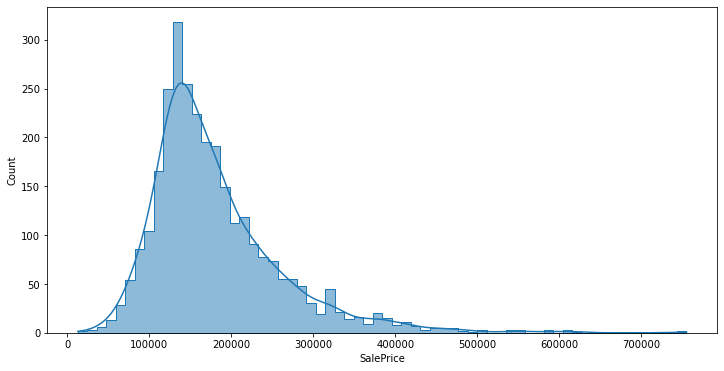

In [5]:
plt.figure(figsize=(12,6),)
sns.histplot(df["SalePrice"], kde=True, element='step')

As we see Sale Price is not normally distributed, and it follows right skewed distribution. We will deal with that later.

In [6]:
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Screen Porch       0.112151
Pool Area          0.068403
Mo Sold            0.035259
3Ssn Porch         0.032225
BsmtFin SF 2       0.005891
Misc Val          -0.015691
Yr Sold           -0.030569
Bsmt Half Bath    -0.035835
Low Qual Fin SF   -0.037660
MS SubClass       -0.085092
Overall Cond      -0.101697
Kitchen AbvGr     -0

As we see some features are stronger corelated with our target than others. We will examine some plotes of ones that can affect our model the badliest.

<AxesSubplot:xlabel='Overall Qual', ylabel='SalePrice'>

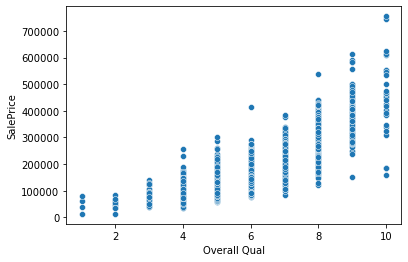

In [7]:
sns.scatterplot(x='Overall Qual',y='SalePrice',data=df)

Everything looks as expected. The higher the quality, the higher the price.

<AxesSubplot:xlabel='Gr Liv Area', ylabel='SalePrice'>

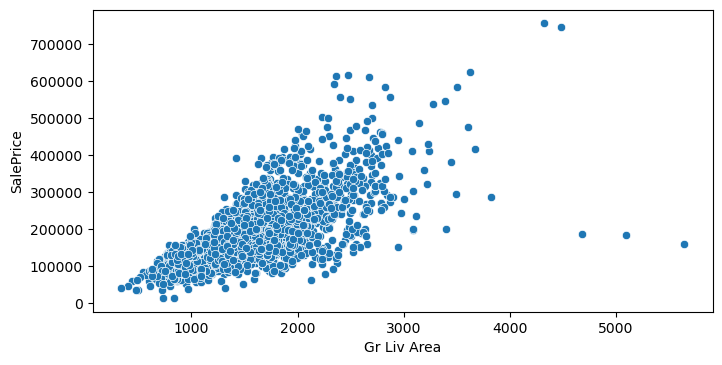

In [8]:
plt.figure(figsize=(8,4), dpi=100)
sns.scatterplot(x='Gr Liv Area', y="SalePrice", data=df)

As it seems, relation between Sale Price, and Living Area is line. On both plots we can see thoug, that there are some properties of high quality and big area, that are significantly cheaper than others in their group. Lets find which rows are those.

In [9]:
df[(df["SalePrice"]<300000) & (df['Gr Liv Area']>4000) & (df['Overall Qual']>8)]


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1498,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2180,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850
2181,908154205,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


They look suspicious. We should delete them.

In [10]:
ind_drop=df[(df["SalePrice"]<300000) & (df['Gr Liv Area']>4000) & (df['Overall Qual']>8)].index
df = df.drop(ind_drop, axis=0)

<AxesSubplot:xlabel='Gr Liv Area', ylabel='SalePrice'>

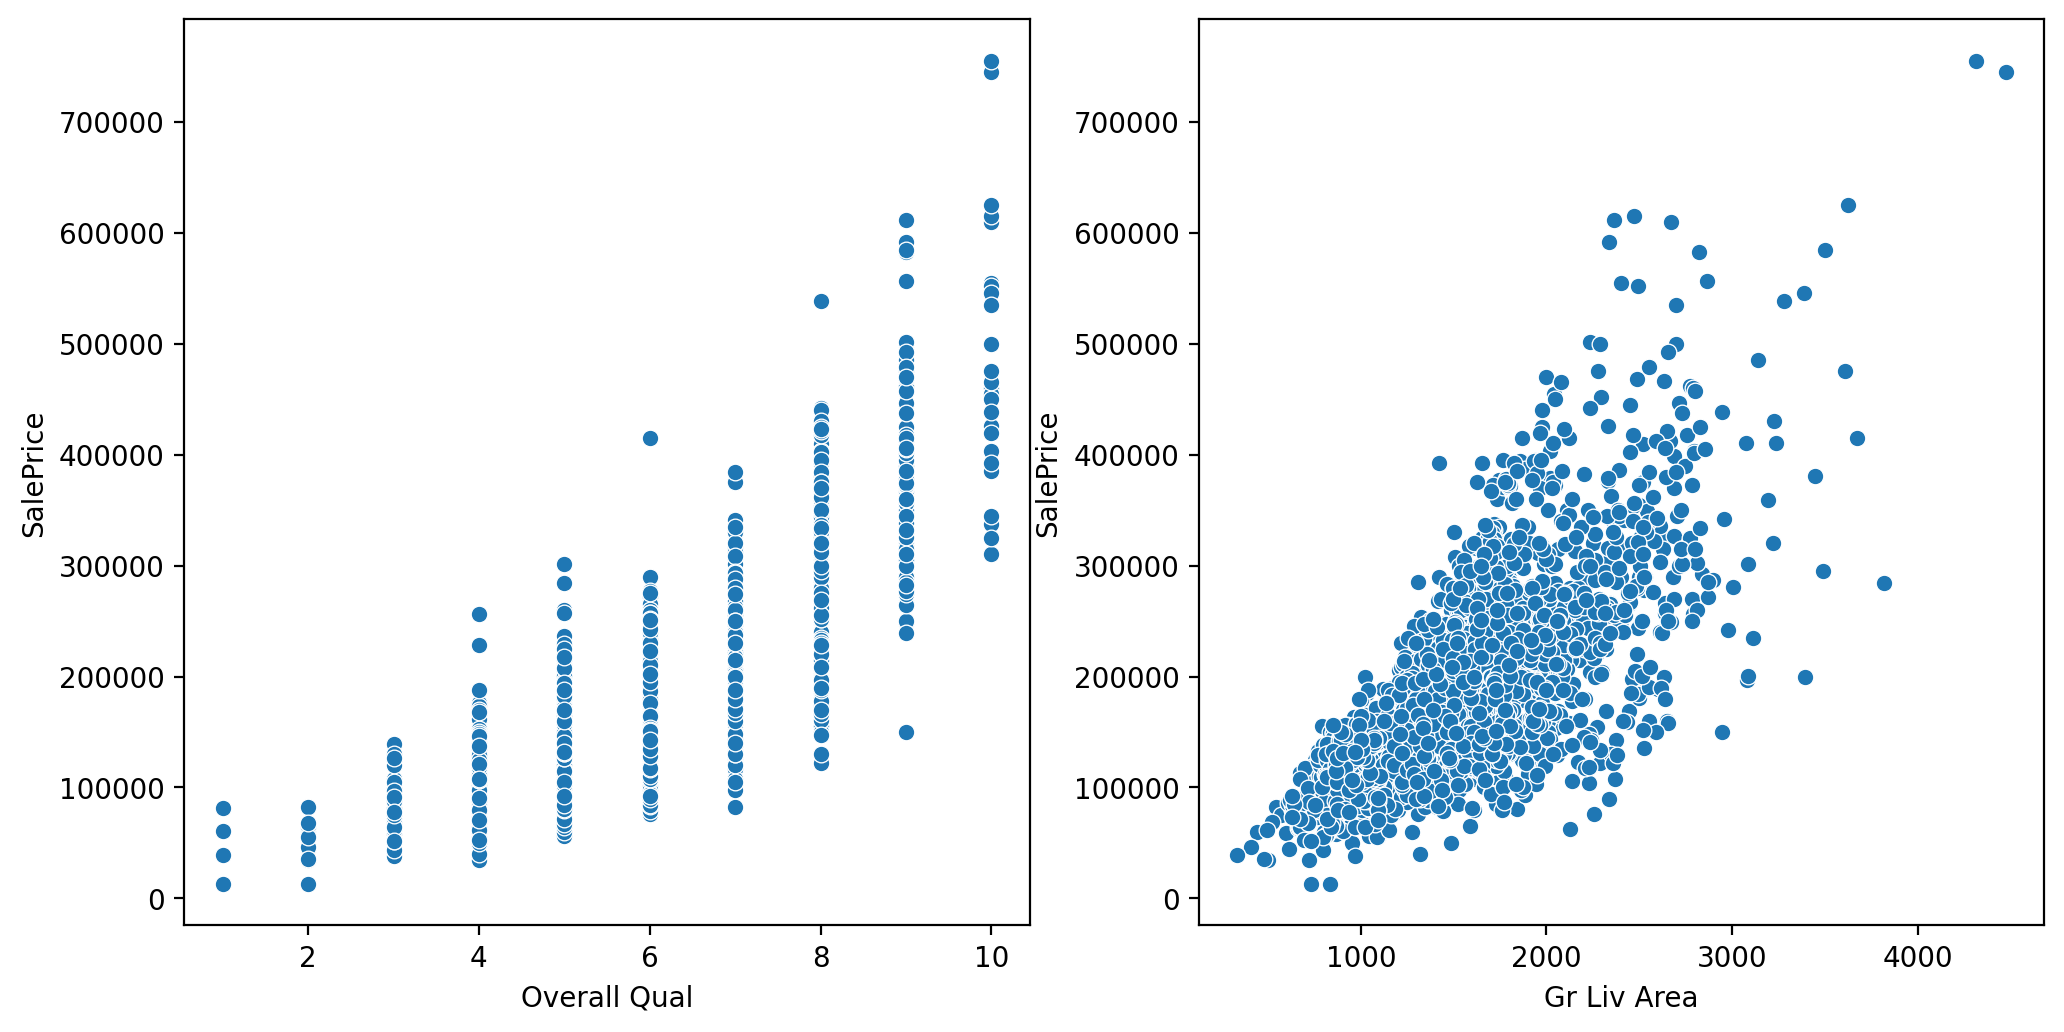

In [11]:
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (12, 6), dpi=200)
sns.scatterplot(x='Overall Qual',y='SalePrice',data=df, ax=axes[0])
sns.scatterplot(x='Gr Liv Area', y="SalePrice", data=df, ax=axes[1])

And they are out of our dataset. 

<AxesSubplot:xlabel='Garage Area', ylabel='SalePrice'>

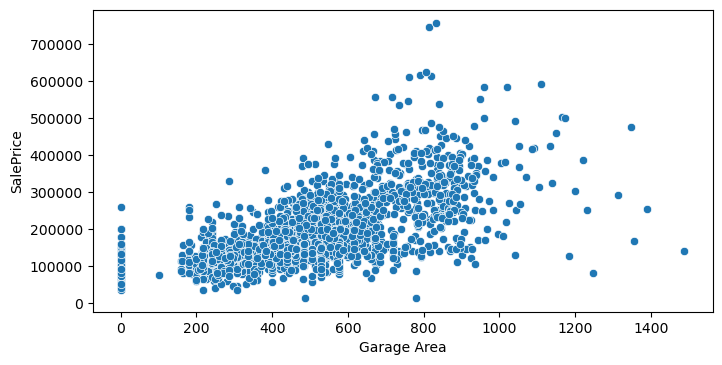

In [12]:
plt.figure(figsize=(8,4), dpi=100)
sns.scatterplot(x='Garage Area', y="SalePrice", data=df)

Relationship between Price and Garage Area looks rather linear. We can see that there is a group of houses with garage area equal to zero. These are just houses without garages.

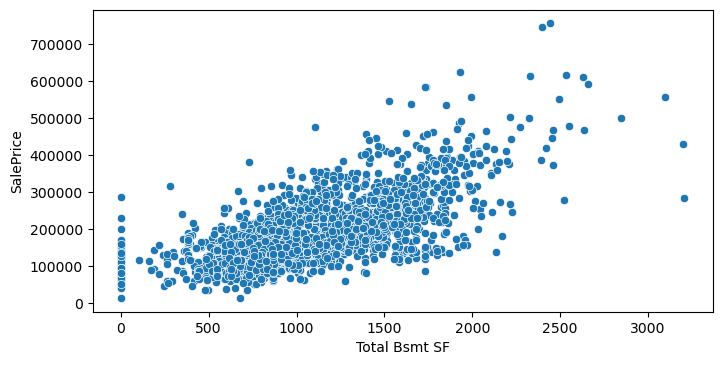

In [13]:
plt.figure(figsize=(8,4), dpi=100)
g=sns.scatterplot(x='Total Bsmt SF', y="SalePrice", data=df)

Same applies to basement square footage.

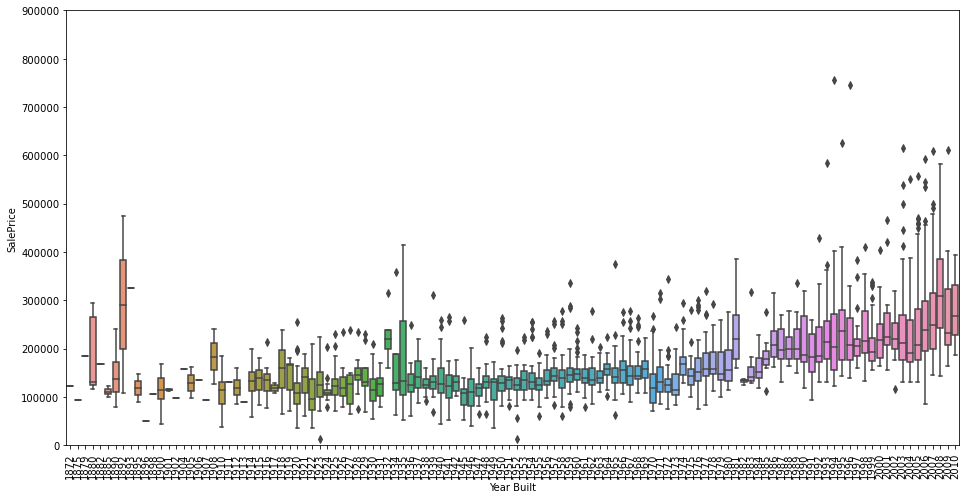

In [14]:
fig, axes = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='Year Built', y="SalePrice", data=df)
fig.axis(ymin=0, ymax=900000);
plt.xticks(rotation=90);

We can see that generally newer houses are trading at higher prices.

# Preprocessing

## Missing Data
To deal with missing data we will work closely with dataset documentation

In [15]:
with open('Ames_Housing_Feature_Description.txt','r') as f: 
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [16]:
len(df)

2927

In [17]:
#checking NaN entries
df.isnull().sum().sort_values(ascending=False)

Pool QC         2915
Misc Feature    2822
Alley           2729
Fence           2355
Fireplace Qu    1422
                ... 
MS SubClass        0
Central Air        0
1st Flr SF         0
2nd Flr SF         0
SalePrice          0
Length: 81, dtype: int64

As we can see some features are nearly empty. Now I will write function that takes data frame as an input, and returns a series showing percentage of empty entries, and plot them on a barplot.

In [18]:
def p_missing(df):
    percent = 100*df.isnull().sum()/len(df)
    percent = percent[percent>0].sort_values()
    if df.isnull().values.sum() > 0:
        plot = sns.barplot(x=percent.index,y=percent)
        plt.xticks(rotation=90);
    if df.isnull().values.sum() > 0:
        return plot
    return percent

<AxesSubplot:>

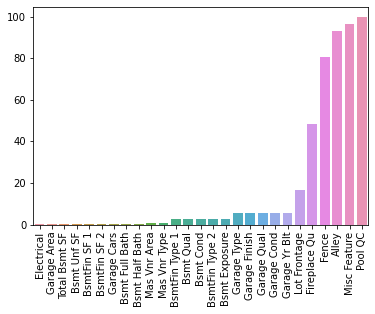

In [19]:
p_missing(df)

In [20]:
df['Pool QC'] = df['Pool QC'].fillna("None")

<AxesSubplot:>

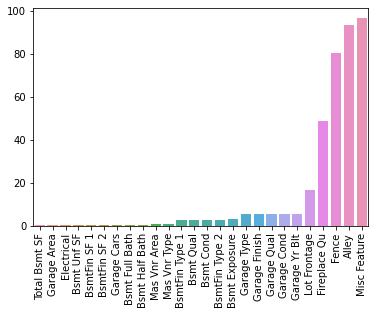

In [21]:
p_missing(df)

In [22]:
#Data desc says NA means no misc feature
df['Misc Feature'] = df['Misc Feature'].fillna('None')
#Data desc says NA means no alley acces
df['Alley'] = df['Alley'].fillna('None')
#Data desc says NA means no fence
df['Fence'] = df['Fence'].fillna('None')
#Data desc says NA means no fireplace
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')

<AxesSubplot:>

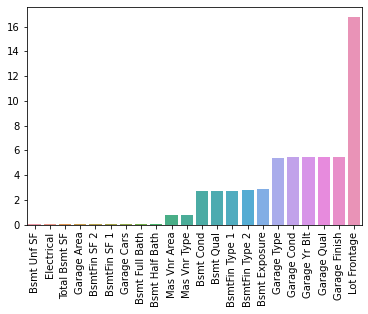

In [23]:
p_missing(df)

Lot frontage is a tricky one, beacouse authors of a data set didnt tell us what NA means. We will assume that Lot Frontage is related to Neighborhood, and fill NA's with mean of lot frontage for given neighborhood.

In [24]:
df['Lot Frontage'] = df.groupby('Neighborhood')['Lot Frontage'].transform(lambda v: v.fillna(v.mean))

<AxesSubplot:>

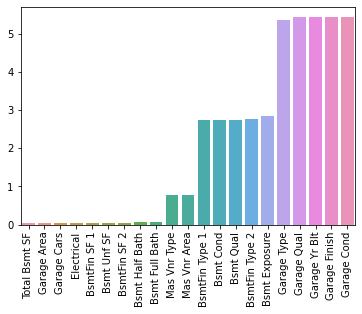

In [25]:
p_missing(df)

In [26]:
#Categorical garage features. NA means no garage
garage_cat = ['Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type', 'Garage Yr Blt']
df[garage_cat] = df[garage_cat].fillna('None')
#Numerical garage features. NA means 0
garage_num = ['Garage Area', 'Garage Cars']
df[garage_num] = df[garage_num].fillna(0)

<AxesSubplot:>

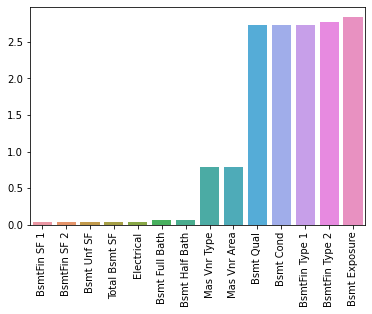

In [27]:
p_missing(df)

<AxesSubplot:>

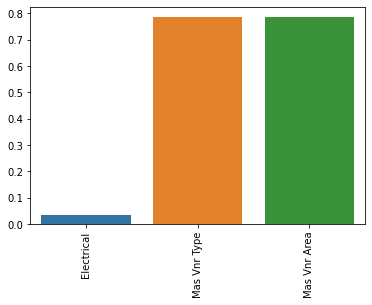

In [28]:
#Categorical basement features. NA means no basement
basement_cat = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
df[basement_cat] = df[basement_cat].fillna('None')
#Numerical basement features. NA means 0
basement_num = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
df[basement_num] = df[basement_num].fillna(0)
p_missing(df)

<AxesSubplot:>

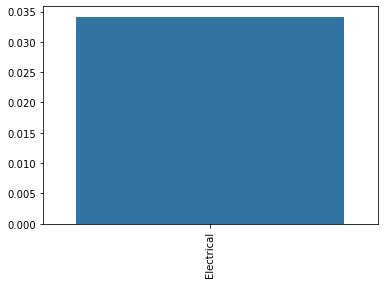

In [29]:
# Masonry veener features. NA means none or 0
df['Mas Vnr Area']=df['Mas Vnr Area'].fillna(0)
df['Mas Vnr Type']=df['Mas Vnr Type'].fillna('None')
p_missing(df)

In [30]:
df[df['Electrical'].isnull()]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1577,916386080,80,RL,73.0,9735,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2008,WD,Normal,167500


The last missing point is part of feature Electrical. Data desscription says that it is suposed to show type of electrical system. Since its higly unlikely that NA means no electricity acces at all, and it is only one observation, I will delete the missing row.

In [31]:
df = df.dropna(axis=0, subset = ['Electrical'])
p_missing(df)

Series([], dtype: float64)

## Dealing with skewness
As shown by first plot in this notebook, our target variable is slightly right skewed. Normality of target variable is one of the assumptions of linear model. In order to achive it I will log transform Price varable.

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

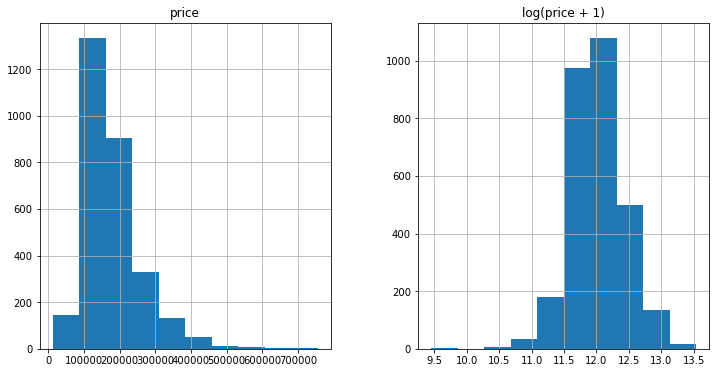

In [32]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price + 1)":np.log1p(df["SalePrice"])})
prices.hist()

In [33]:
#Log transforming target variable
df['SalePrice'] = np.log1p(df['SalePrice'])

In [34]:
def loger(df):
    features_num = df.dtypes[df.dtypes != "object"].index
    skewed_features = df[features_num].apply(lambda x: skew(x))
    skewed_features = skewed_features[skewed_features > 0.5]
    skewed_features = skewed_features.index
    df[skewed_features] = np.log1p(df[skewed_features])
    print('Loger transformed ' + str(len(skewed_features)) + ' features.')
    return df


In [35]:
df = loger(df)

Loger transformed 24 features.


In [36]:
df_num = df.select_dtypes(exclude='object')
df_cat = df.select_dtypes(include='object')
df_cat = pd.get_dummies(df_cat, drop_first=True)
df_final = pd.concat([df_num, df_cat], axis = 1)


In [37]:
df_final.dtypes

PID                         int64
MS SubClass               float64
Lot Area                  float64
Overall Qual                int64
Overall Cond              float64
                           ...   
Sale Condition_AdjLand      uint8
Sale Condition_Alloca       uint8
Sale Condition_Family       uint8
Sale Condition_Normal       uint8
Sale Condition_Partial      uint8
Length: 529, dtype: object

In [38]:
df_final.shape

(2926, 529)

As we dealt with missing, and categorical data, and transformed some features as well, our data frame is ready for modeling. However we can see that one hot encoding realy changed our features/observations ratio. Having that many features may intoduce us some problems. For exapmle some of them might be colinear. To deal with that problem I will use four different models and compare their outcome. After using standard linear reggresion I will try Ridge Reggression, Lasso Regression, and Elastic Net model. Those techniques can perform feature selection for us (and that is why we didn't do that earlier).

# Models

## Linear regression

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error 

In [40]:
X = df_final.drop(['SalePrice'], axis= 1)
y = df_final['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69)


Due to variety of scales and units I standardize the features.

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [43]:
linear_model_preds = linear_model.predict(X_test)

In [75]:
#Model metrics
linear_model_MAE = mean_absolute_error(y_test, linear_model_preds)
linear_model_MSE = mean_squared_error(y_test, linear_model_preds)
linear_model_RMSE = np.sqrt(linear_model_MSE)
print(linear_model_RMSE)
print(linear_model_MAE)


54991086326.2039
5879486400.597861


4582791552.462924

That doest look good. On average we are off by 54991086326 dolars (yes, thats 10 numbers ageter 5) and square root of mean squared error is 5879486400 dolars (thats only 9 numbers but still terrible outcome).

## Ridge regression

In [45]:
from sklearn.linear_model import RidgeCV

In [46]:
ridge_cv_model = RidgeCV(alphas=(np.linspace(1,500,500)),scoring='neg_mean_absolute_error')

In [47]:
ridge_cv_model.fit(X_train, y_train)
ridge_cv_model.alpha_

237.0

In [48]:
test_predictions = ridge_cv_model.predict(X_test)

In [49]:
ridge_cv_MAE = mean_absolute_error(y_test,test_predictions)
ridge_cv_MSE = mean_squared_error(y_test,test_predictions)
ridge_cv_RMSE = np.sqrt(ridge_cv_MSE)

In [50]:
ridge_cv_MAE

0.0809561026578348

In [51]:
ridge_cv_RMSE

0.1154866831874576

## Lasso regression

In [52]:
from sklearn.linear_model import LassoCV

In [53]:
lasso_cv_model = LassoCV(eps = 0.01, n_alphas=200, cv = 10)

In [54]:
lasso_cv_model.fit(X_train,y_train)

LassoCV(cv=10, eps=0.01, n_alphas=200)

In [55]:
lasso_cv_model.alpha_

0.0033766862012321285

In [56]:
lasso_test_predictions = lasso_cv_model.predict(X_test)

In [57]:
lasso_cv_MAE = mean_absolute_error(y_test,lasso_test_predictions)
lasso_cv_MSE = mean_squared_error(y_test,lasso_test_predictions)
lasso_cv_RMSE = np.sqrt(lasso_cv_MSE)

In [58]:
lasso_cv_MAE

0.07418961083695572

In [74]:
lasso_cv_RMSE

0.10644114357480221

In [60]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [61]:
elastic_model = ElasticNet()

In [62]:
param_grid = {'alpha':[.001,0.1,1,5,10,20,50,70,100],
             'l1_ratio':[.001,.1, .5, .7, .9, .25, .5, .75, .95, .99, 1]}

In [63]:
grid_model = GridSearchCV(estimator=elastic_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5)

In [64]:
grid_model.fit(X_train,y_train)

C:\Users\konie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.345595628575332, tolerance: 0.034719864625329715
  model = cd_fast.enet_coordinate_descent(
C:\Users\konie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.162264434843211, tolerance: 0.03472113091926798
  model = cd_fast.enet_coordinate_descent(
C:\Users\konie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.096447286420142, tolerance: 0.03474520041305725
  model = cd_fast.enet_coordinate_descent(
C:\Users\konie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergenc

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20, 50, 70, 100],
                         'l1_ratio': [0.001, 0.1, 0.5, 0.7, 0.9, 0.25, 0.5,
                                      0.75, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error')

In [65]:
grid_model.best_params_

{'alpha': 0.001, 'l1_ratio': 1}

In [66]:
elastic_model_preds = grid_model.predict(X_test)

In [77]:
elastic_MAE=mean_absolute_error(y_test, elastic_model_preds)
elastic_MAE

0.0735260476292873

In [79]:
elastic_MSE=mean_squared_error(y_test, elastic_model_preds)
elastic_RMSE=np.sqrt(elastic_MSE)
elastic_RMSE

0.1070622003331592

# Conclusions
All three regularized models perform nearly the same, and they are trying to predict the same values so we can decide by choosing the lowest value of error metrics. It would be either Lasso model if we are deciding by root mean squared error, or elastic net by mean absolute error. Since MAE is easier to interpret (mean deviation of prediction from target variable), and less prone to inflation caused by outliers I would recommend to pick lower MAE over RMSE and go with elastic net model.
Since Im only trying to predict Sale Price I will not interpret the coefficents here (but one day I'd like to add section on it, since it is important part of the analysis)

#### Disclaimer:
This notebook is my attempt to check the capabilities of python and its environment in regards to linear models and play with it. It by no means comply to standards accpeted by econometricians, however I'd like to bring it to those standards one day, but first I want to complete my project on time series forecasting. 